In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from collections import defaultdict, deque
from IPython.display import display, HTML

%matplotlib inline
%qtconsole

In [3]:
buildings_path = '/data/server/OpenSolarMap/buildings.csv'
contribs_path = '/data/server/OpenSolarMap/contribs.csv'

buildings = pd.read_csv(buildings_path, names=['building', 'shape', 'surface', 'angle', 'orientation'])
contribs = pd.read_csv(contribs_path, names=['building', 'orientation', 'user', 'timestamp'])
contribs['timestamp'] = pd.to_datetime(contribs.timestamp)
contribs.sort_values(by='timestamp', inplace=True)

In [4]:
good_buildings = buildings[(buildings.orientation == 1) | (buildings.orientation == 2) | (buildings.orientation == 3)]
good_buildings.set_index('building', inplace=True)

In [5]:
def compute_time(t):
    return t.hour + t.minute/60 + t.second/(60*60) + t.microsecond/(60*60*1000000)
contribs['time'] = contribs.timestamp.map(compute_time)

In [6]:
contribs['response_time'] = 0
contribs['count_good_responses'] = 0
contribs['count_unsure_responses'] = 0
contribs['count_bad_responses'] = 0
contribs['responses_last_20_mn'] = 0
contribs['label'] = 0
last_response = defaultdict(lambda : -1)
count_good_responses = defaultdict(int)
count_unsure_responses = defaultdict(int)
count_bad_responses = defaultdict(int)
responses_last_20_mn = defaultdict(deque)
twenty_minutes = pd.Timedelta(20, unit='m')
for i, r in contribs.iterrows():
    # response time
    lr = last_response[r.user]
    if lr == -1:
        contribs.set_value(i, 'response_time', pd.Timedelta(1, unit='d'))
    else:
        contribs.set_value(i, 'response_time', r.timestamp - lr)
    last_response[r.user] = r.timestamp
    
    # response counts and label
    contribs.set_value(i, 'count_good_responses', count_good_responses[r.user])
    contribs.set_value(i, 'count_unsure_responses', count_unsure_responses[r.user])
    contribs.set_value(i, 'count_bad_responses', count_bad_responses[r.user])
    if r.building in good_buildings.index:
        true_orientation = good_buildings.loc[r.building].orientation
        if r.orientation == true_orientation:
            count_good_responses[r.user] += 1
            contribs.set_value(i, 'label', 1)
        elif r.orientation == 4:
            count_unsure_responses[r.user] += 1
        else:
            count_bad_responses[r.user] += 1
            contribs.set_value(i, 'label', -1)
    else:
        if r.orientation == 4:
            count_unsure_responses[r.user] += 1

    # response count in last 20 minutes
    lower_bound = r.timestamp - twenty_minutes
    while responses_last_20_mn[r.user] and responses_last_20_mn[r.user][0] < lower_bound:
        responses_last_20_mn[r.user].popleft()
    contribs.set_value(i, 'responses_last_20_mn', len(responses_last_20_mn[r.user]))
    responses_last_20_mn[r.user].append(r.timestamp)

In [7]:
contribs['response_time_seconds'] = contribs.response_time.map(lambda d: d / np.timedelta64(1,'s'))
contribs['total_count'] = contribs.count_good_responses + contribs.count_unsure_responses + contribs.count_bad_responses
contribs['good_rate'] = contribs.count_good_responses / contribs.total_count
contribs['unsure_rate'] = contribs.count_unsure_responses / contribs.total_count
contribs['bad_rate'] = contribs.count_bad_responses / contribs.total_count
contribs['good_rate_2'] = contribs.count_good_responses / (contribs.count_good_responses + contribs.count_bad_responses)

In [8]:
features = ['orientation', 'time', 'responses_last_20_mn', 'response_time_seconds', 'total_count', 'good_rate', 'unsure_rate', 'bad_rate', 'good_rate_2', 'label']
dataset = contribs[contribs.label!=0]
dataset = dataset[features]

In [9]:
len(dataset[dataset.label==-1])

1998

In [10]:
HTML(dataset[dataset.label==-1].to_html())

,orientation,time,responses_last_20_mn,response_time_seconds,total_count,good_rate,unsure_rate,bad_rate,good_rate_2,label
217,2,11.192629,9,2.788138,42,0.190476,0.809524,0.000000,1.000000,-1
718,2,12.782677,95,1.874764,22,0.500000,0.500000,0.000000,1.000000,-1
1575,2,13.721956,334,2.191048,47,0.574468,0.425532,0.000000,1.000000,-1
2516,1,16.595678,44,4.288963,160,0.187500,0.806250,0.006250,0.967742,-1
2609,2,17.091820,1,4.268635,0,NaN,NaN,NaN,NaN,-1
2802,1,17.473182,56,8.326523,29,0.068966,0.931034,0.000000,1.000000,-1
2935,2,17.639623,34,3.882351,2,0.500000,0.500000,0.000000,1.000000,-1
3044,2,17.780147,97,7.962885,30,0.066667,0.900000,0.033333,0.666667,-1
3109,1,17.885020,8,5.981815,1,0.000000,1.000000,0.000000,NaN,-1
3441,2,18.242990,6,3.827543,3,0.000000,1.000000,0.000000,NaN,-1


In [11]:
contribs.iloc[30882]

building                                   202477521
orientation                                        2
user                                      032a1425b3
timestamp                 2015-11-11 04:08:56.517035
time                                         4.14903
response_time                 0 days 00:00:00.743114
count_good_responses                              57
count_unsure_responses                             2
count_bad_responses                              153
responses_last_20_mn                             286
label                                             -1
response_time_seconds                       0.743114
total_count                                      212
good_rate                                   0.268868
unsure_rate                               0.00943396
bad_rate                                    0.721698
good_rate_2                                 0.271429
Name: 30882, dtype: object

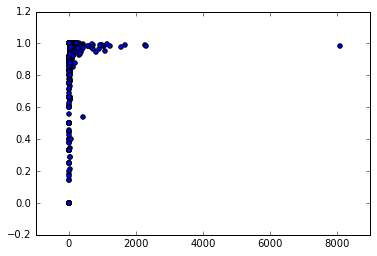

In [12]:
x = []
y = []
for user in contribs.user.unique():
    count_total = count_good_responses[user] + count_bad_responses[user]
    if count_total:
        x.append(count_total)
        y.append(count_good_responses[user] * 1. / count_total)
plt.scatter(x, y)

In [13]:
nb_errors = 0
nb_correct = 0
bad_users = []
for user in contribs.user.unique():
    count_total = count_good_responses[user] + count_bad_responses[user]
    if count_total:
        user_precision = count_good_responses[user] * 1. / count_total
        if user_precision < 0.7:
            bad_users.append(user)
            nb_errors += count_bad_responses[user]
            nb_correct += count_good_responses[user]
print(nb_errors)
print(nb_correct)
print(len(bad_users))

725
560
191


In [14]:
clean_contribs = contribs[contribs.apply(lambda r: r.user not in bad_users, axis=1)]
clean_dataset = clean_contribs[contribs.label!=0]
clean_dataset = clean_dataset[features]

/home/michel/.virtualenvs/solar/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [15]:
len(clean_dataset[clean_dataset.label==-1])

1273

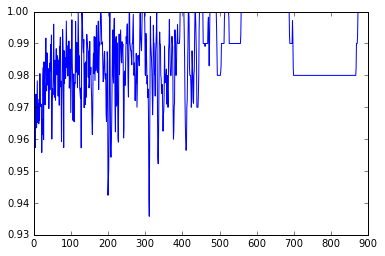

In [16]:
renormalized_labels = clean_dataset[['responses_last_20_mn', 'label']].copy()
renormalized_labels['label'] = (renormalized_labels.label + 1) / 2
renormalized_labels.sort_values(by='responses_last_20_mn', inplace=True)

renormalized_labels.label = pd.rolling_mean(renormalized_labels.label, 100)
fatigue_effect_smoothed = renormalized_labels.groupby('responses_last_20_mn')['label'].mean()

plt.plot(fatigue_effect_smoothed)

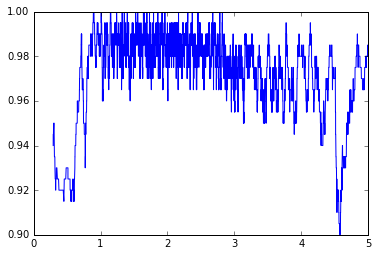

In [18]:
renormalized_labels = clean_dataset[['response_time_seconds', 'label']].copy()
renormalized_labels['label'] = (renormalized_labels.label + 1) / 2
renormalized_labels = renormalized_labels[renormalized_labels.response_time_seconds < 5]
renormalized_labels.sort_values(by='response_time_seconds', inplace=True)

renormalized_labels.label = pd.rolling_mean(renormalized_labels.label, 200)

plt.plot(renormalized_labels.set_index('response_time_seconds'))